# Extracting Urban Features from Raster Data

In [1]:
import geopandas as gpd
from tobler.dasymetric import extract_raster_features
import matplotlib.pyplot as plt
%load_ext watermark
%watermark -v -d -u -p tobler,geopandas,rasterio

Last updated: 2021-01-24

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

tobler   : 0.6.0
geopandas: 0.8.1
rasterio : 1.1.5



## Fetching boundary data on the fly

We'll use osmnx to grab a geodataframe of the UK boundary

In [2]:
import osmnx as ox

In [3]:
uk = ox.geocode_to_gdf('united kingdom')

<AxesSubplot:>

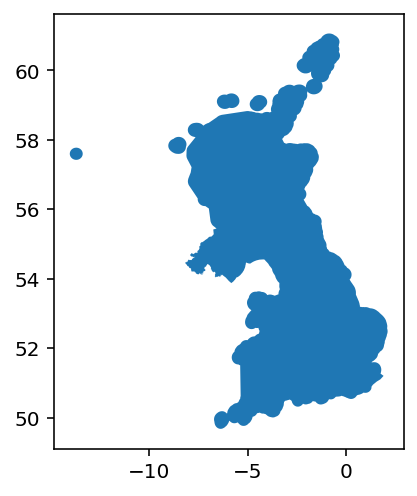

In [4]:
uk.plot()

## Extracting raster features

When interpolating data like population counts, a common strategy for improving accuracy is to incorporate ancillary data that can improve estimation by masking out uninhabited areas. A commonly-used data source for this purpose is land use/land cover (LULC) data collected from from remote sensing and satellite imagery. But these data can also be difficult to work with because they're often distributed in large raster files that can be difficult to process alongside polygonal vector data. To assist, `tobler` provides the `extract_raster_features` function that consumes raster data and converts (a subset) of pixel values into polygon features represented by a geopandas GeoDataFrame.

As an example, consider [Copernicus](https://land.copernicus.eu/global/products/lc) which provides global, annual LULC data at a 100m pixel resolution. According to their [documentation](https://land.copernicus.eu/global/sites/cgls.vito.be/files/products/CGLOPS1_PUM_LC100m-V3_I3.3.pdf) "Urban / built up" areas are denoted with the value 50.

In the next cell we'll read in copernicus data from the web and extract all the urban cells from the raster

In [5]:
urban_uk = extract_raster_features(uk, 'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2015/W020N60/W020N60_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif', pixel_values=[50])

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


The function returns a geodataframe with rows corresponding to regions of the input raster with contiguous pixels of the same cell value. Since we only extracted cells with value 50, every row in this geodataframe has the same value

In [6]:
urban_uk.head()

,value,geometry
0,50.0,"POLYGON ((-1.24603 60.00000, -1.24603 59.99901..."
1,50.0,"POLYGON ((-1.25694 59.99802, -1.25694 59.99702..."
2,50.0,"POLYGON ((-1.24504 59.99702, -1.24504 59.99603..."
3,50.0,"POLYGON ((-1.22520 59.99702, -1.22520 59.99603..."
4,50.0,"POLYGON ((-1.24206 59.99008, -1.24206 59.98810..."


<AxesSubplot:>

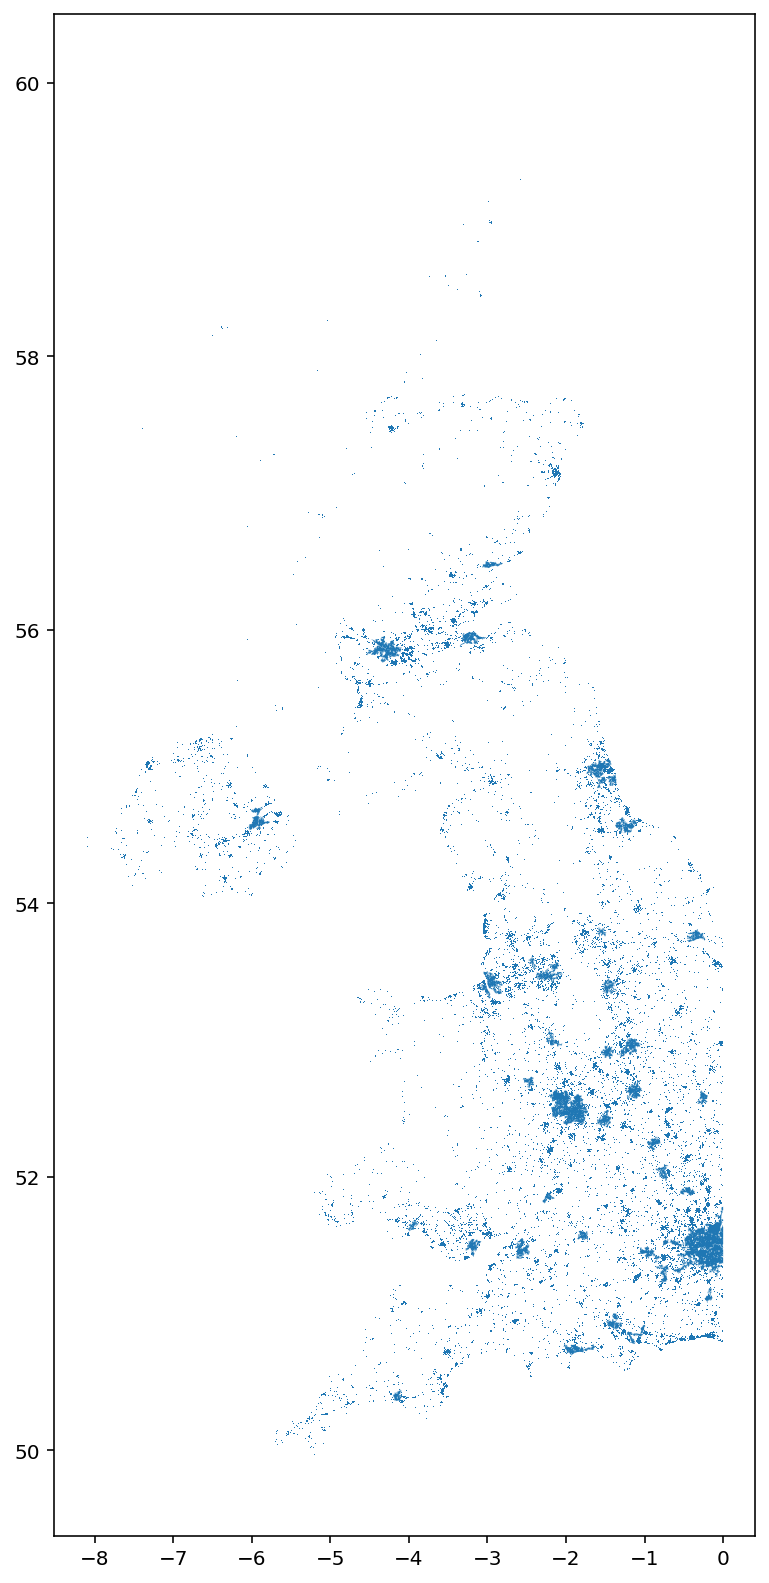

In [7]:
fig, ax = plt.subplots(figsize=(20,14))
urban_uk.plot(ax=ax)

Note: the raster doesn't cover the whole country, so we see the hard edge appear on the eastern side. To do this properly, we could run this function again with the next raster tile from Copernicus, then concatenate the results

## Extracting development intensity

In addition to copernicus, other data sources may contain additional or more precise data. For example, the [National Land Cover Database]() (NLCD) provides land-use classification for the USA at a 30m pixel resolution. LULC classification in NLCD is also more detailed, with [four categories](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend) of developed land, with different cell values denoting different intensities

In [8]:
la = ox.geocode_to_gdf('los angeles county')

<AxesSubplot:>

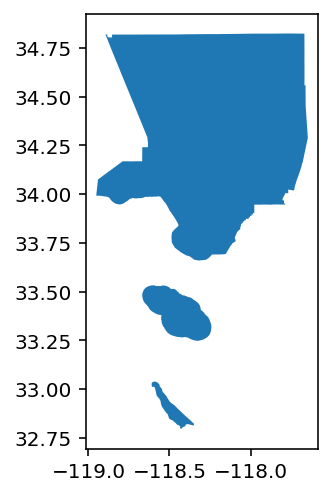

In [9]:
la.plot()

In [10]:
la = la.to_crs(6424)

Now we'll call `extract_raster_features` again, but this time we'll read a compressed version of NLCD data from the [spatialucr](spatial.ucr.edu) quilt [bucket](https://open.quiltdata.com/b/spatial-ucr/packages/) and extract the values 21, 22, 23, and 24 which represent developed land of different intensities

In [11]:
urban_la = extract_raster_features(la, "s3://spatial-ucr/rasters/nlcd/nlcd_2011.tif", pixel_values=[21,22,23,24])

In [12]:
urban_la.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 409905 entries, 0 to 409904
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   value     409905 non-null  float64 
 1   geometry  409905 non-null  geometry
dtypes: float64(1), geometry(1)
memory usage: 6.3 MB


Since NCLD is a fairly high-resolution raster and LA county is large, the resulting geodataframe 

In [13]:
urban_la.head()

,value,geometry
0,23.0,"POLYGON ((-2057115.000 1555425.000, -2057115.0..."
1,22.0,"POLYGON ((-2057115.000 1555395.000, -2057115.0..."
2,22.0,"POLYGON ((-2057055.000 1555395.000, -2057055.0..."
3,22.0,"POLYGON ((-2057145.000 1555365.000, -2057145.0..."
4,22.0,"POLYGON ((-2056965.000 1555365.000, -2056965.0..."


Since we extracted multiple pixel types, the values in this geodataframe differ, and plotting the geodataframe reveals how development varies across LA county

In [14]:
urban_la = urban_la.to_crs(6424)

<AxesSubplot:>

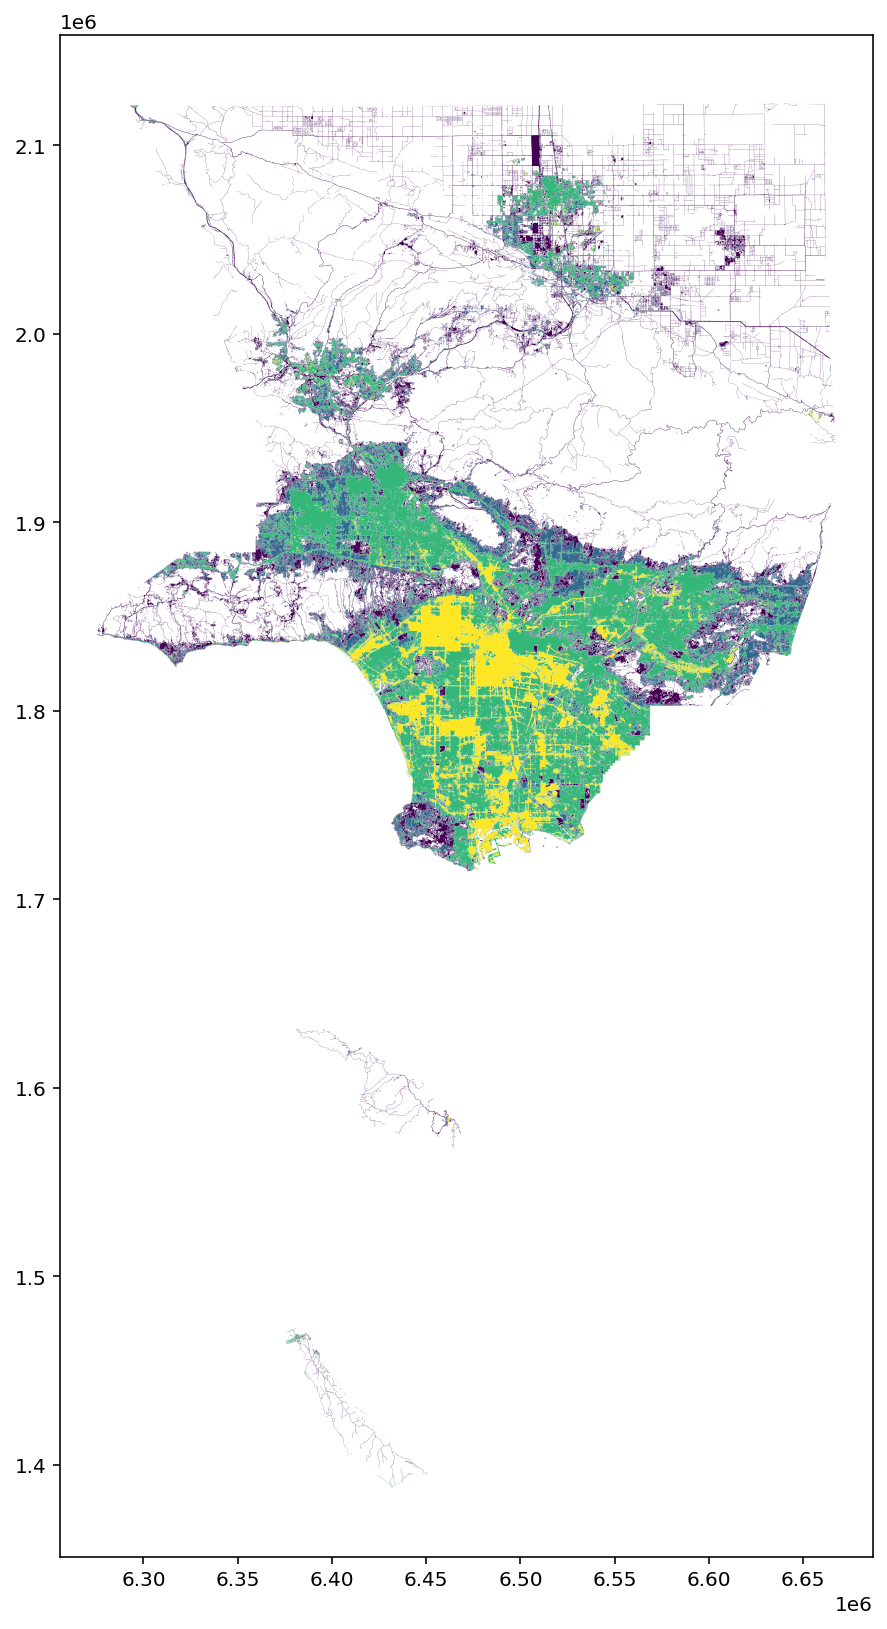

In [15]:
fig, ax = plt.subplots(figsize=(20,14))
urban_la.plot('value', ax=ax)

From here, these data can be used to clip source features prior to areal interpolation or used in additional data processing pipelines. Alternatively, we might have extracted water and forestry features we know *aren't* inhabited, and used the resulting features in reverse

If you want to extract features from multiple cell values but don't need to represent variation, you can pass `collapse_values=True`, which will generate a geodataframe with fewer rows. As an example, if we wanted to extract the area in LA county that is at least 25% impervious surface, but we only care whether the area is impervious or not (regardless of the *level* of imperviousness) we could do the following.

Here, I've downloaded a different product from NLCD that defines imperviousness, and we'll extract all cell values between 25 and 100 but collapse the values, so we end up with a discrete representation of imperviousness

In [16]:
impervious_la = extract_raster_features(la, "/Users/knaaptime/Downloads/NLCD_Impervious_L48_20190405_full_zip/nlcd_impervious_2016.tif", pixel_values=list(range(25,101)), collapse_values=True)

/Users/knaaptime/anaconda3/envs/tobler/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
impervious_la.head()

,geometry
0,"POLYGON ((-2057115.000 1555425.000, -2057115.0..."
1,"POLYGON ((-2057025.000 1555395.000, -2057025.0..."
2,"POLYGON ((-2056965.000 1555365.000, -2056965.0..."
3,"POLYGON ((-2056935.000 1555335.000, -2056935.0..."
4,"POLYGON ((-2056845.000 1555335.000, -2056845.0..."


In [18]:
impervious_la.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37519 entries, 0 to 37518
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  37519 non-null  geometry
dtypes: geometry(1)
memory usage: 293.2 KB


<AxesSubplot:>

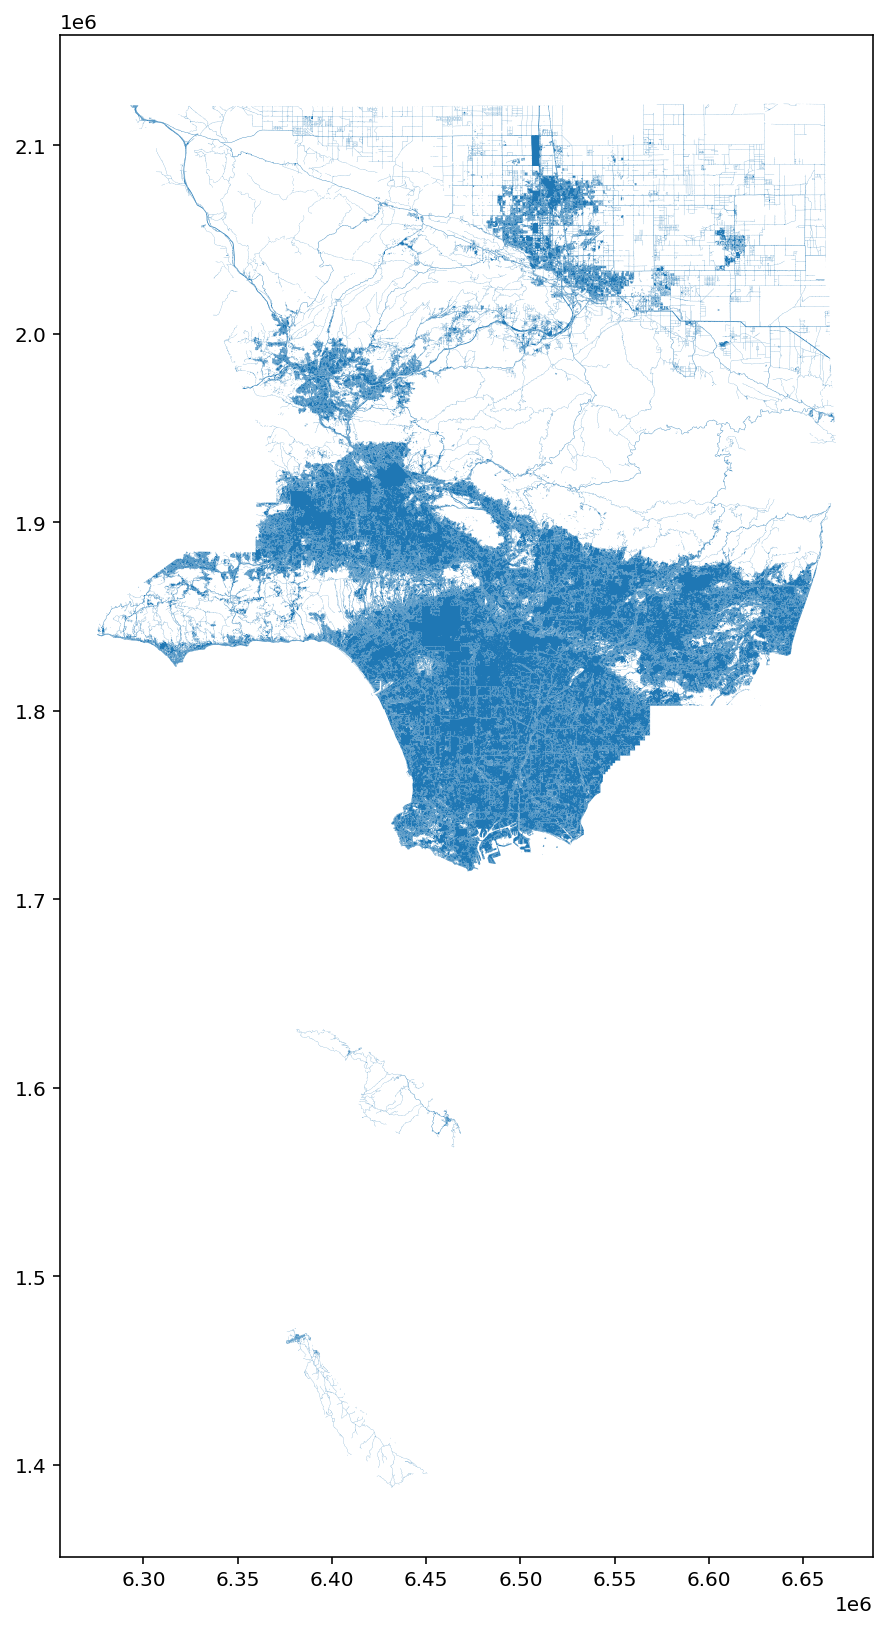

In [19]:
fig, ax = plt.subplots(figsize=(20,14))
urban_la.plot(ax=ax)